In [1]:
# rad1_multistep_periodic.py
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import splu

# -------------------- Config --------------------
SEED = 7
rng = np.random.default_rng(SEED)

# Linear RAD params (stable)
Du = 0.01
c  = 0.1
alpha = -1.0

# Nonlinear term (damping)
kappa = -1.0  # -kappa*u^2

# Grid / time
Nx = 100
Lx = 1.0
x_grid = np.linspace(0.0, Lx, Nx, endpoint=False)
dx = x_grid[1] - x_grid[0]

Ts      = 2e-2
T_steps = 21
N_traj  = 1000

# Multi-input control
n_u      = 8
MIN_HOLD, MAX_HOLD = 1, 4
U_AMP = 0.25

SAVE_PATH = "rad1_multistep_periodic.npz"

# -------------------- Build control basis B(x) (periodic cosines) --------------------
B = np.zeros((Nx, n_u))
for i in range(1, n_u + 1):
    B[:, i-1] = np.cos(2*np.pi*i*x_grid/Lx)
col_norms = np.sqrt(np.sum(B**2, axis=0) * dx)
B /= (col_norms + 1e-12)

# -------------------- Spatial operators (PERIODIC) --------------------
e = np.ones(Nx)

# Periodic Laplacian
L = sparse.diags([e, -2*e, e], offsets=[-1, 0, 1], shape=(Nx, Nx)).tolil()
L[0, -1] = 1.0
L[-1, 0] = 1.0
L = (L / dx**2).tocsr()

I = sparse.eye(Nx, format="csr")
Au = (I - Ts*Du*L).tocsr()
lu_u = splu(Au.tocsc())

# -------------------- Helpers --------------------
def make_prbs_matrix(T, n_u, amp, rng, min_hold=10, max_hold=40):
    U = np.empty((n_u, T))
    for i in range(n_u):
        seq = np.empty(T)
        t = 0
        while t < T:
            hold = int(rng.integers(min_hold, max_hold + 1))
            val = amp if rng.random() < 0.5 else -amp
            seq[t:t+hold] = val
            t += hold
        U[i] = seq[:T]
    return U

def smooth_random_periodic(x, Lx, K=16, decay=0.0, std=1.0, rng=np.random.default_rng(0)):
    """
    Periodic zero-mean IC ~ sum_k a_k cos(2πkx/Lx) + b_k sin(2πkx/Lx)
    """
    u = np.zeros_like(x)
    for k in range(1, K+1):
        scale = np.exp(-decay * k**2)
        ak = rng.standard_normal() * scale
        bk = rng.standard_normal() * scale
        u += ak * np.cos(2*np.pi*k*x/Lx) + bk * np.sin(2*np.pi*k*x/Lx)
    u -= u.mean()
    s = u.std()
    if s > 0:
        u *= (std / s)
    return u

def advective_flux_upwind_periodic(u, dx, c):
    """
    Periodic upwind derivative du/dx (first order).
    Uses backward diff if c>=0, forward diff if c<0.
    """
    if c >= 0.0:
        dudx = (u - np.roll(u, 1)) / dx      # backward
    else:
        dudx = (np.roll(u, -1) - u) / dx     # forward
    return -c * dudx

def rad1_step(u, a_vec):
    """One IMEX-Euler step for 1D RAD with multi-input control (periodic)."""
    adv  = advective_flux_upwind_periodic(u, dx, c)
    reac = alpha * u
    nl   = -(kappa * u**2)
    c_u  = B @ a_vec
    rhs  = u + Ts * (adv + reac + nl + c_u)
    u_next = lu_u.solve(rhs)
    return u_next

# -------------------- Dataset generation --------------------
def generate_dataset(N_traj, T_steps, Ts, rng):
    n = Nx
    Xs, Ys, Us = [], [], []
    for _ in range(N_traj):
        u = smooth_random_periodic(x_grid, Lx, K=16, decay=0.0, std=1.0, rng=rng)
        U_seq = make_prbs_matrix(T_steps, n_u, U_AMP, rng, MIN_HOLD, MAX_HOLD)
        X_traj = np.empty((n, T_steps))
        for k in range(T_steps):
            X_traj[:, k] = u
            u = rad1_step(u, U_seq[:, k])
        Xs.append(X_traj[:, :-1])
        Ys.append(X_traj[:, 1:])
        Us.append(U_seq[:, :-1])
    X = np.stack(Xs, axis=0)
    Y = np.stack(Ys, axis=0)
    U = np.stack(Us, axis=0)
    return X, Y, U

# -------------------- Main --------------------
if __name__ == "__main__":
    X, Y, U = generate_dataset(N_traj, T_steps, Ts, rng)
    np.savez_compressed(
        SAVE_PATH, X=X, Y=Y, U=U,
        Ts=Ts, Nx=Nx, Lx=Lx, dx=dx, n_u=n_u,
        Du=Du, c=c, alpha=alpha, kappa=kappa,
        B=B, B_desc="columns are cosine control shapes b_i(x) (L2-normalized, periodic)",
        N_traj=N_traj, T_steps=T_steps,
        meta=dict(description="1-species nonlinear RAD (IMEX FD) with multi-input control, PERIODIC BCs",
                  seed=SEED, N_traj=N_traj, T_steps=T_steps,
                  state_dim=Nx, input_dim=n_u)
    )
    print("Saved:", SAVE_PATH)
    print("Shapes: X", X.shape, "Y", Y.shape, "U", U.shape, "| B:", B.shape)


Saved: rad1_multistep_periodic.npz
Shapes: X (1000, 100, 20) Y (1000, 100, 20) U (1000, 8, 20) | B: (100, 8)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------- loader (1 field only) --------------------
def load_rad1(npz_path="rad1_multistep_periodic.npz", traj_index=0, return_full_U=True):
    """
    Returns:
      u_mat : (Nx, T)   state
      U_seq : (m, T-1)  controls (if return_full_U) else (T-1,) first channel
      x, t, Ts, B, dx, data
    """
    data = np.load(npz_path, allow_pickle=True)
    X, Y, U = data["X"], data["Y"], data["U"]            # (N_traj, n, T-1), (N_traj, n_u, T-1)
    Ts = float(data["Ts"]); Nx = int(data["Nx"]); Lx = float(data["Lx"]); dx = float(data["dx"])
    n  = X.shape[1]; Tm1 = X.shape[2]
    assert n == Nx, f"Dataset is not 1-field: n={n}, Nx={Nx}"

    X_traj = X[traj_index]                                # (Nx, T-1)
    Y_traj = Y[traj_index]                                # (Nx, T-1)
    u_mat  = np.concatenate([X_traj, Y_traj[:, -1][:, None]], axis=1)  # (Nx, T)
    U_seq  = U[traj_index] if return_full_U else U[traj_index, 0]       # (m,T-1) or (T-1,)

    x = np.linspace(0.0, Lx, Nx, endpoint=False)
    t = np.arange(Tm1 + 1) * Ts
    B = data["B"]
    return u_mat, U_seq, x, t, Ts, B, dx, data


# -------------------- spacetime (1 field) --------------------
def plot_spacetime1(u_mat, x, t, center_zero=False, title="u(x,t)"):
    fig, ax = plt.subplots(1, 1, figsize=(5.6, 3.6), constrained_layout=True)
    if center_zero:
        vmax = np.nanmax(np.abs(u_mat)); vmin, vmax = -vmax, vmax
        im = ax.pcolormesh(t, x, u_mat, shading="auto", vmin=vmin, vmax=vmax)
    else:
        im = ax.pcolormesh(t, x, u_mat, shading="auto")
    ax.set_title(title); ax.set_xlabel("t"); ax.set_ylabel("x")
    fig.colorbar(im, ax=ax); plt.show()


# -------------------- means/norms + inputs (1 field) --------------------
def plot_means_norms1(u_mat, U_seq, t, show_inputs="norm", B=None, dx=None):
    """
    show_inputs: "none" | "norm" (||u(t)||2) | "fieldnorm" (||B u(t)||_L2)
    U_seq: (m,T-1) or (T-1,) if single channel
    """
    Nx, T = u_mat.shape
    mean_u = u_mat.mean(axis=0)
    nrm_u  = np.sqrt((u_mat*u_mat).mean(axis=0))  # ||·||2 / √Nx

    fig, axs = plt.subplots(2, 1, figsize=(8.0, 4.8), sharex=True, constrained_layout=True)
    axs[0].plot(t, mean_u, label="mean(u)")
    axs[0].set_ylabel("spatial mean"); axs[0].grid(True, alpha=0.3); axs[0].legend()

    axs[1].plot(t, nrm_u, label="‖u(·,t)‖₂/√Nₓ")
    if show_inputs != "none" and U_seq is not None:
        if np.ndim(U_seq) == 1:
            U2 = U_seq[None, :]              # (1, T-1)
        else:
            U2 = U_seq                        # (m, T-1)
        if show_inputs == "norm":
            axs[1].step(t[:-1], np.linalg.norm(U2, axis=0), where="post", label="‖u(t)‖₂", alpha=0.85)
        elif show_inputs == "fieldnorm":
            assert B is not None and dx is not None, "Need B, dx for fieldnorm."
            if U2.shape[0] == 1 and B.shape[1] > 1:
                # use first actuator column if only one channel passed
                Bu = B[:, [0]] * U2          # (Nx, T-1)
            else:
                if B.shape[1] != U2.shape[0]:
                    raise ValueError(f"B has {B.shape[1]} cols but U_seq has {U2.shape[0]} rows.")
                Bu = B @ U2                  # (Nx, T-1)
            Bu_L2 = np.sqrt(np.sum(Bu*Bu, axis=0) * dx)
            axs[1].step(t[:-1], Bu_L2, where="post", label="‖B u(t)‖_L2", alpha=0.85)
    axs[1].set_xlabel("t"); axs[1].set_ylabel("norm / input"); axs[1].grid(True, alpha=0.3); axs[1].legend()
    plt.show()


# -------------------- profiles (1 field) --------------------
def plot_profiles1(u_mat, x):
    fig, ax = plt.subplots(1, 1, figsize=(7.0, 3.2), constrained_layout=True)
    ax.plot(x, u_mat[:, 0],  "-",  lw=1.7, label="u(x,0)")
    ax.plot(x, u_mat[:, -1], "--", lw=1.7, label="u(x,T)")
    ax.set_xlabel("x"); ax.set_ylabel("value"); ax.set_title("Initial vs final")
    ax.grid(True, alpha=0.3); ax.legend(); plt.show()


In [3]:
import numpy as np
d1_op = lambda u: (u - np.roll(u, 1)) / dx if c >= 0 else (np.roll(u, -1) - u) / dx
L_op = lambda v: L @ v
rad_step = rad1_step
make_inputs = lambda T: make_prbs_matrix(T, n_u, U_AMP, rng, MIN_HOLD, MAX_HOLD)
u0 = smooth_random_periodic(x_grid, Lx, K=16, decay=0, std=1.0, rng=rng)

# ---------- L2 over space ----------
def l2_space(field, dx):
    """Discrete L2(Ω) norm: ||f||_L2 ≈ sqrt(Σ_j f_j^2 Δx)."""
    f = np.asarray(field, dtype=np.float64).ravel()
    return float(np.sqrt(np.sum(f*f) * dx))

# ---------- per-term magnitudes for RAD-1D (periodic) ----------
def term_sizes_rad1(u, a_vec, *, B, dx, Du, c, alpha, kappa, d1_op=None, L_op=None):
    """
    L2 magnitudes of each PDE term for 1D RAD with distributed input.
    PDE: y_t = Du*y_xx - c*y_x + alpha*y - kappa*y^2 + B@a
    Arguments marked * are keyword-only to make call-sites explicit.

    Parameters
    ----------
    u : (Nx,) array   current state
    a_vec : (m,)      current control vector
    B : (Nx,m)        actuator matrix (columns are b_i(x))
    dx : float        grid spacing
    Du, c, alpha, kappa : floats  PDE coefficients
    d1_op : callable  first-derivative operator, d1_op(u) -> y_x  (e.g., upwind)
    L_op  : callable  Laplacian operator,  L_op(u) -> y_xx        (or matrix @)

    Returns
    -------
    dict with L2 magnitudes per term and totals.
    """
    # Input field
    u_in = B @ a_vec                        # (Nx,)

    # Derivatives
    ux  = d1_op(u) if callable(d1_op) else None
    uxx = L_op(u)  if callable(L_op)  else None

    # Individual term fields (pointwise contributions on RHS)
    adv   = -c * ux                        if ux  is not None else 0.0
    diff  =  Du * uxx                      if uxx is not None else 0.0
    linr  =  alpha * u
    nl    = -kappa * (u**2)                # NOTE: κ>0 => damping; κ<0 => destabilizing

    # L2 magnitudes
    out = {
        "adv":   l2_space(adv,  dx) if ux  is not None else 0.0,
        "diff":  l2_space(diff, dx) if uxx is not None else 0.0,
        "linr":  l2_space(linr, dx),
        "nl":    l2_space(nl,   dx),
        "input": l2_space(u_in, dx),
    }

    # Totals
    rhs_no_input = (adv if ux is not None else 0.0) + (diff if uxx is not None else 0.0) + linr + nl
    rhs_with_in  = rhs_no_input + u_in
    out["rhs_no_input"]  = l2_space(rhs_no_input, dx)
    out["rhs_with_input"] = l2_space(rhs_with_in,  dx)
    return out

def pretty_print_sizes(sizes, prefix=""):
    order = ["adv","diff","linr","nl","input","rhs_no_input","rhs_with_input"]
    s = " | ".join(f"{k}: {sizes[k]:.3e}" for k in order)
    print((prefix + " " if prefix else "") + s)

# ---------- measure over a rollout using YOUR integrator ----------
def measure_term_sizes_over_rollout(T_meas, *, rng, rad_step, make_inputs, u0,
                                    B, dx, Du, c, alpha, kappa, d1_op, L_op):
    """
    Accumulate average per-term L2 magnitudes over T_meas steps.

    rad_step(u, a_vec) must advance by one step exactly as in your solver.
    make_inputs(T) must return (m, T) control sequence aligned with steps.
    """
    U_seq = make_inputs(T_meas)          # shape (m, T_meas)
    u = u0.copy()
    acc = None

    for k in range(T_meas):
        sizes = term_sizes_rad1(u, U_seq[:, k], B=B, dx=dx, Du=Du, c=c,
                                alpha=alpha, kappa=kappa, d1_op=d1_op, L_op=L_op)
        if acc is None:
            acc = {key: 0.0 for key in sizes}
        for key in sizes:
            acc[key] += sizes[key]
        u = rad_step(u, U_seq[:, k])     # one IMEX-Euler step (your rad1_step)

    avg = {k: v / T_meas for k, v in acc.items()}
    print(f"Per-term L2 averages over {T_meas} steps:")
    pretty_print_sizes(avg)
    return avg


avg_sizes = measure_term_sizes_over_rollout(
    T_meas=50,
    rng=rng,
    rad_step=rad1_step,
    make_inputs=make_inputs,
    u0=u0,
    B=B, dx=dx, Du=Du, c=c, alpha=alpha, kappa=kappa,
    d1_op=d1_op, L_op=L_op
)

Per-term L2 averages over 50 steps:
adv: 4.303e-01 | diff: 1.819e+00 | linr: 2.459e-01 | nl: 1.507e-01 | input: 7.071e-01 | rhs_no_input: 2.092e+00 | rhs_with_input: 2.271e+00


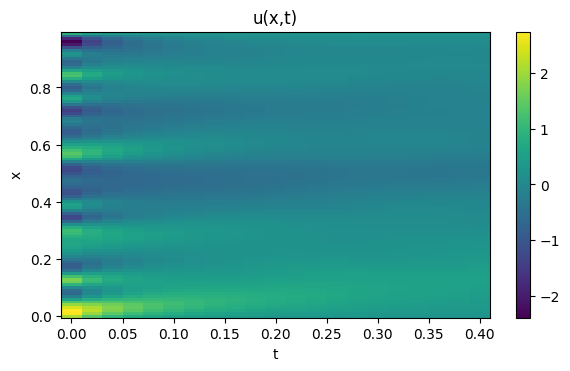

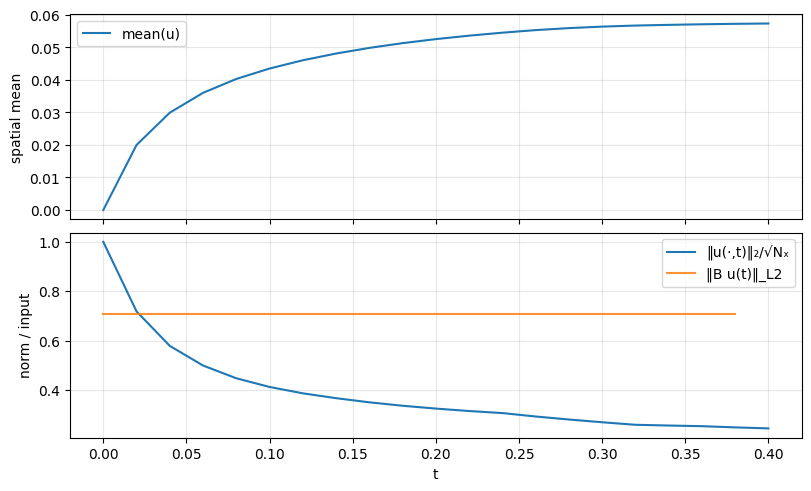

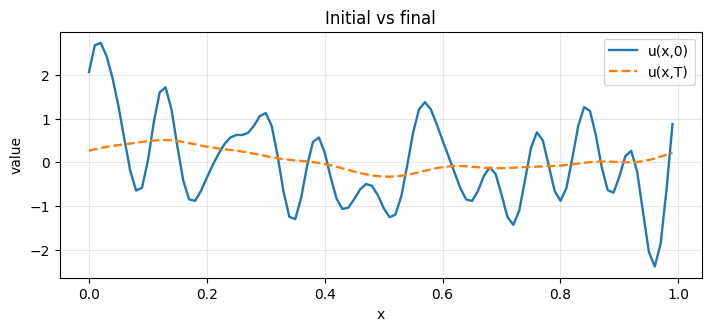

In [4]:

if __name__ == "__main__":
    # choose which trajectory to visualize
    TRAJ_IDX = 60
    u_mat, U_seq, x, t, Ts, B, dx, data = load_rad1("rad1_multistep_periodic.npz", traj_index=TRAJ_IDX)
    plot_spacetime1(u_mat, x, t)
    plot_means_norms1(u_mat,U_seq, t, show_inputs="fieldnorm", B=data["B"], dx=data["dx"])
    plot_profiles1(u_mat, x)

In [5]:
# ---- Fourier projections for 1 field ----
import numpy as np

# -------- helpers (periodic FD) --------
def d1_periodic(u, dx):
    # centered first derivative with periodic wrap
    return (np.roll(u, -1) - np.roll(u, 1)) / (2.0 * dx)

def d2_periodic(u, dx):
    # second derivative (Laplacian in 1D) with periodic wrap
    return (np.roll(u, -1) - 2.0*u + np.roll(u, 1)) / (dx**2)

# -------- Fourier projections (cos & sin) --------
def compute_observables(u, x_grid, Lx, dx, M=10, orthonormal=True):
    """
    Project u(x) onto first M cosine & sine modes on [0, Lx] with periodic BCs.
    Returns array of shape (2*M,): [<u, cos(1)>, ..., <u, cos(M)>, <u, sin(1)>, ..., <u, sin(M)>]
    If orthonormal=True, uses L2-orthonormal scaling on [0, Lx].
    """
    u = np.asarray(u, dtype=np.float64)
    obs = np.zeros(2*M, dtype=np.float64)

    # Orthonormal factors over [0, Lx] (exclude k=0)
    # ∥cos(kπx/Lx)∥^2 = ∥sin(kπx/Lx)∥^2 = Lx/2 for k>=1
    if orthonormal:
        norm_factor = np.sqrt(2.0 / Lx)
    else:
        norm_factor = 1.0

    # precompute trig table
    ks = np.arange(1, M+1, dtype=np.float64)
    ang = 2 * np.pi * np.outer(ks, x_grid / Lx)  # shape (M, Nx)
    cos_tbl = np.cos(ang) * norm_factor
    sin_tbl = np.sin(ang) * norm_factor

    # inner products via Riemann sum
    # first M are cos, next M are sin
    obs[:M]  = (cos_tbl @ u) * dx
    obs[M:]  = (sin_tbl @ u) * dx
    return obs

# -------- main psi builder --------
def make_psi_rad(x_grid, Lx, dx,
                 M=10,
                 include_bias=True,
                 include_fourier=True,
                 include_energy=True,
                 include_cubic_energy=False,
                 include_poly_moments=True,
                 include_diff_stats=True,
                 include_x=False):
    """
    Build a modest, RAD-friendly observable map ψ(u):
      - bias (1)
      - Fourier projections (2M): cos/sin k=1..M (orthonormalized)
      - energy terms: mean(u^2)
      - polynomial moments: mean(u), mean(u^3)   (low-order only)
      - differential stats: mean( (u_x)^2 ), mean( (u_xx)^2 )
      - (optional) raw field u (Nx)   [use sparingly]
    Notes:
      * Periodic BCs assumed for derivatives & Fourier.
      * Keep flags on default for a compact feature vector.
    """
    x_grid = np.asarray(x_grid, dtype=np.float64)
    Nx = x_grid.size

    def psi(u):
        u = np.asarray(u, dtype=np.float64).ravel()
        parts = []

        if include_bias:
            parts.append(np.array([1.0], dtype=np.float64))

        if include_fourier:
            parts.append(compute_observables(u, x_grid, Lx, dx, M=M, orthonormal=True))

        if include_energy:
            # ∫ u^2 dx (or mean) — we use mean to keep scale consistent across grids
            parts.append(u*u)
        if include_cubic_energy:
            parts.append(u**3)

        if include_poly_moments:
            # low-order only: mean(u), mean(u^3)
            parts.append(np.array([np.mean(u), np.mean(u**3)], dtype=np.float64))

        if include_diff_stats:
            ux  = d1_periodic(u, dx)
            uxx = d2_periodic(u, dx)
            # RAD-relevant smoothness/curvature measures
            parts.append(np.array([np.mean(ux*ux), np.mean(uxx*uxx)], dtype=np.float64))

        if include_x:
            # raw field — high-dimensional; leave off unless you really need it
            parts.append(u.copy())

        return np.concatenate(parts).astype(np.float64)

    return psi


def build_initial_blocks(X, U, Y, H, psi=lambda x: x):
    """
    Generic version: psi is any callable that maps x -> lifted features.
    Returns Psi0, U0, Y0, and inferred dimensions.
    """
    N_traj, n, Tm1 = X.shape
    m = U.shape[1]
    assert H <= Tm1, "H must be <= T_steps-1"

    # infer p from first sample
    psi0 = psi(X[0, :, 0])
    psi0 = np.asarray(psi0).ravel()
    p = psi0.size

    Psi0 = np.empty((N_traj, p))
    U0   = np.empty((N_traj, H * m))
    Y0   = np.empty((N_traj, H * n))

    for i in range(N_traj):
        x0 = X[i, :, 0]
        Psi0[i] = np.asarray(psi(x0)).ravel()
        U0[i]   = U[i, :, :H].ravel()
        Y0[i]   = Y[i, :, :H].ravel()

    return Psi0, U0, Y0, p, n, m

Shapes: Psi0 (1000, 301) U0 (1000, 160) Y0 (1000, 2000)
[[ 1.00000000e+00  8.46819936e+00  6.94713941e+00 ...  2.08571240e+00
   4.58245499e-01 -1.62144809e+00]
 [ 1.00000000e+00  1.02311032e-01  3.16037119e-01 ...  2.10889700e+00
   1.43735302e+00  4.40972787e-01]
 [ 1.00000000e+00  3.81885996e-01  3.74611622e-01 ... -1.37760842e+00
  -8.41426602e-01 -3.54007945e-04]
 ...
 [ 1.00000000e+00  2.63232286e+00  3.17819270e+00 ... -1.49897345e+00
  -4.58146789e-01  7.78061896e-01]
 [ 1.00000000e+00  2.49351817e-01  4.72711696e-03 ...  1.01993123e-01
   5.79449218e-01  7.40146631e-01]
 [ 1.00000000e+00  4.22491343e-03  2.24890100e-02 ...  1.46030514e+00
   1.64213572e+00  9.31776868e-01]]
Cond(Psi0): 9.741732862789318e+16
Cond(U0): 5.9643220152949965
Singular values of Psi0: [3.20703523e+02 2.30405827e+02 2.24060762e+02 2.18783424e+02
 2.14549795e+02 2.13639852e+02 2.11334514e+02 2.07938418e+02
 2.06921059e+02 2.05503533e+02 2.03167330e+02 2.00762763e+02
 2.00257698e+02 1.96791833e+02 1.9468

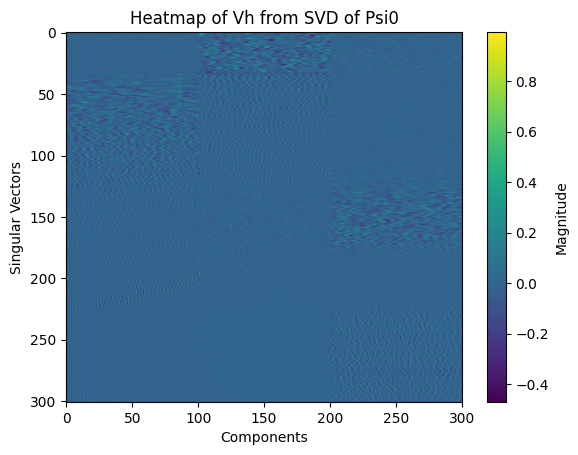

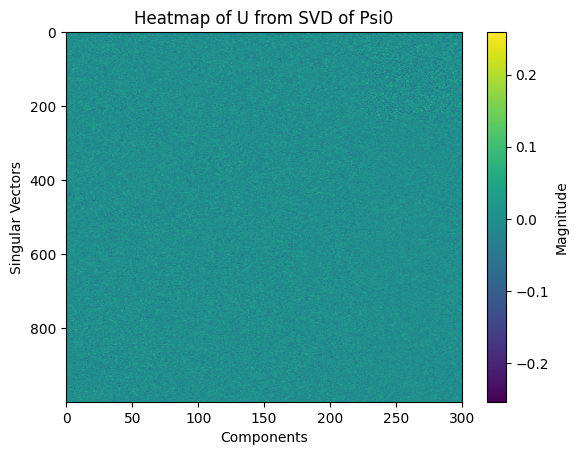

In [8]:
# ---- load or create your data as numpy arrays (columns = samples) ----
# X: (n, N), Y: (n, N), U: (m, N), THETA: (N,)
# For demo, we'll create placeholders; replace these with your data.
# ---------- build features (ψ) ----------
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import splu
if __name__ == "__main__":
    data = np.load("rad1_multistep_periodic.npz", allow_pickle=True)
    X = data["X"]      # (N_traj, n, T-1)
    U = data["U"]      # (N_traj, m, T-1)
    Y = data["Y"]      # (N_traj, n, T-1)
    Nx = int(data["Nx"]); Lx = float(data["Lx"]); n_u = int(data["n_u"])
    meta = {"dx": dx, "dt": float(data["Ts"])}

    # split by trajectories
    N_traj = X.shape[0]
    n_train = int(1.0*N_traj)
    Xtr, Utr , Ytr  = X[:n_train], U[:n_train], Y[:n_train]
    Xte, Ute , Yte = X[n_train:], U[n_train:], Y[n_train:]

    # choose horizon and lift hyperparams
    H = T_steps - 1
    lift_kwargs =  dict()

    # build initial-only blocks
    # build initial-only blocks
    psi = make_psi_rad(x_grid, Lx, dx,
                       M=30,
                       include_bias=True,
                       include_fourier=False,
                       include_energy=True,
                       include_cubic_energy=True,
                       include_poly_moments=False,
                       include_diff_stats=False,
                       include_x=True)

    Psi0, U0, Y0, p, n, m = build_initial_blocks(Xtr, Utr, Ytr, H, psi=psi)
    print("Shapes: Psi0", Psi0.shape, "U0", U0.shape, "Y0", Y0.shape)
    #print condition numbers
    from numpy.linalg import cond
    print(Psi0)
    print("Cond(Psi0):", cond(Psi0))
    print("Cond(U0):", cond(U0))
    #check svd
    from numpy.linalg import svd
    U_svd, S_svd, Vh_svd = svd(Psi0, full_matrices=False)
    print("Singular values of Psi0:", S_svd)
    print("rank of Psi0:", np.sum(S_svd > 1e-3))
    #heatmap of Vh_svd
    import matplotlib.pyplot as plt
    plt.imshow(Vh_svd, aspect='auto', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title('Heatmap of Vh from SVD of Psi0')
    plt.xlabel('Components')
    plt.ylabel('Singular Vectors')
    plt.show()
    #heatmap of U_svd
    plt.imshow(U_svd, aspect='auto', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title('Heatmap of U from SVD of Psi0')
    plt.xlabel('Components')
    plt.ylabel('Singular Vectors')
    plt.show()


In [9]:
import numpy as np
import cvxpy as cp
from joblib import Parallel, delayed
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

# ------------------------------------------------------------
# Row-wise CVXPY solve: one output i at horizon step k
# ------------------------------------------------------------
from sklearn.linear_model import ElasticNet
def solve_row(G, Hk, y, beta=1e-3, tau=1e-2):
    """
    Solve min || G Ei_k + Hk Fi_k - y ||^2
            + beta ( ||[Ei_k; Fi_k]||_2^2 + tau ||Ei_k||_1 )
    """
    # G: (M,p), Hk: (M,k*m), y: (M,)
    # returns Ei_k: (p,), Fi_k: (k*m,), status
    Phi = np.concatenate([G, Hk], axis=1)   # (M, p + k*m)
    p = G.shape[1]                          # size of Ei_k
    d = Phi.shape[1]                        # p + k*m

    w = cp.Variable(d)      # stack [Ei_k; Fi_k]
    Ei = w[:p]              # first p entries
    Fi = w[p:]              # rest

    loss = cp.sum_squares(Phi @ w - y)  # fit term
    reg  = beta * (cp.sum_squares(w) + tau * cp.norm1(Ei))
    prob = cp.Problem(cp.Minimize(loss + reg))
    prob.solve(solver=cp.OSQP, verbose=False)

    return w.value[:p], w.value[p:], prob.status


# ------------------------------------------------------------
# Parallel fit for all outputs, for each k = 0..H-1
# ------------------------------------------------------------
def fit_edmdc_initial_only_parallel(Psi0, U0, Y0, n, m, H, beta=1e-3, tau=1e-2, n_jobs=-1):
    """
    Inputs
    ------
    Psi0 : (M, p)             ψ(x_0) per trajectory (M = #trajectories used for training)
    U0   : (M, H*m)           stacked inputs [u_0,...,u_{H-1}]
    Y0   : (M, H*n)           stacked targets [x_1,...,x_H] (each x_* ∈ R^n)
    n    : state dimension
    m    : input dimension
    H    : horizon
    Returns
    -------
    E_list : list length H, each E_k of shape (n, p)
    F_list : list length H, each F_k of shape (n, (k+1)*m)
    status : list length H, each a list of solver statuses per output
    """
    M, p = Psi0.shape
    assert U0.shape == (M, H*m)
    assert Y0.shape == (M, H*n)

    E_list, F_list, status_list = [], [], []

    for k in range(H):
        q = (k + 1) * m
        G = Psi0                                   # (M, p)
        Hk = U0[:, :q] if q > 0 else None          # (M, q) or None

        # targets y for this step (all outputs): y_i = column from Y0
        # Y0 layout is [x1|x2|...|xH]; take block k
        Yk = Y0[:, k*n:(k+1)*n]                    # (M, n)

        # parallel across outputs i = 0..n-1
        results = Parallel(n_jobs=n_jobs, prefer="threads")(
            delayed(solve_row)(G, Hk, Yk[:, i], beta=beta, tau=tau)
            for i in range(n)
        )

        E_k = np.vstack([res[0] for res in results])           # (n, p)
        F_k = np.vstack([res[1] for res in results]) if q > 0 else np.zeros((n, 0))
        statuses = [res[2] for res in results]

        E_list.append(E_k)
        F_list.append(F_k)
        print("E_k size: ", E_k.shape)
        print("F_k size: ", F_k.shape)
        status_list.append(statuses)

    return E_list, F_list, status_list

# ------------------------------------------------------------
# Convenience: package E,F into big blocks for prediction
# ------------------------------------------------------------
def stitch_EF_blocks(E_list, F_list, n, p, m, H):
    """
    Make E (H*n, p) and F (H*n, H*m) by placing row-blocks:
      X_{1:H} ≈ E ψ(x0) + F vec(u_0...u_{H-1})
    F is block lower-triangular when viewed per-step, but we store dense.
    """
    E = np.zeros((H*n, p))
    F = np.zeros((H*n, H*m))
    for k in range(H):
        E[k*n:(k+1)*n, :] = E_list[k]
        q = (k+1)*m
        F[k*n:(k+1)*n, :q] = F_list[k]   # remaining columns stay zero
    return E, F

In [10]:
# Build initial-only blocks using your Fourier lift (Option A)
# Psi0: (M,p), U0: (M, H*m), Y0: (M, H*n)
Psi0, U0, Y0, p, n, m = build_initial_blocks(Xtr, Utr, Ytr, H, psi=psi)
# Parallel fit
n_x = Y.shape[1]
H = Y.shape[2]
E_array = []
F_array = []
statuses_array = []
G = Psi0
for k in range(H):
    n_jobs = -1
    Hk = U[:,:,0:k+1].reshape(U[:,:,0:k+1].shape[0], -1)  # shape (2,12)
    results = Parallel(n_jobs=n_jobs)(
            delayed(solve_row)(G, Hk, Y[:, i, k], beta=1e-3, tau=1e-2)
            for i in range(n_x)
        )
    E_k = np.vstack([res[0] for res in results])   # (n_x, p)
    F_k = np.vstack([res[1] for res in results])   # (n_x, k*m)
    statuses = [res[2] for res in results]
    E_array.append(E_k)
    F_array.append(F_k)
    statuses_array.append(statuses)
    print(E_k.shape)
    print(F_k.shape)


# (Optional) check statuses
# print([set(s) for s in statuses])  # expect 'optimal' / 'solved'



# Predict from a new initial window


(100, 301)
(100, 8)
(100, 301)
(100, 16)
(100, 301)
(100, 24)
(100, 301)
(100, 32)
(100, 301)
(100, 40)
(100, 301)
(100, 48)
(100, 301)
(100, 56)
(100, 301)
(100, 64)
(100, 301)
(100, 72)
(100, 301)
(100, 80)
(100, 301)
(100, 88)
(100, 301)
(100, 96)
(100, 301)
(100, 104)
(100, 301)
(100, 112)
(100, 301)
(100, 120)
(100, 301)
(100, 128)
(100, 301)
(100, 136)
(100, 301)
(100, 144)
(100, 301)
(100, 152)
(100, 301)
(100, 160)


In [11]:
# Stitch into big E,F for prediction
# Stack E vertically: (H*n_x, p)
E = np.vstack(E_array)

# Assemble block-lower-triangular F: (H*n_x, H*m)
n_x, p = E_array[0].shape
m = F_array[-1].shape[1] // H if H > 1 else F_array[0].shape[1]
F = np.zeros((H * n_x, H * m))

for k in range(H):
    row_start = k * n_x
    row_end   = (k+1) * n_x
    col_end   = F_array[k].shape[1]
    F[row_start:row_end, :col_end] = F_array[k]

print(E.shape)
print(F.shape)

# save E and F 
np.savez_compressed("rad1_edmdc_initial_only_EF.npz", E=E, F=F)
print("Saved E,F to rad1_edmdc_initial_only_EF.npz")
print(E.shape)
print(F.shape)

(2000, 301)
(2000, 160)
Saved E,F to rad1_edmdc_initial_only_EF.npz
(2000, 301)
(2000, 160)


In [12]:
#load E and F
data_ef = np.load("rad1_edmdc_initial_only_EF.npz")
E = data_ef["E"]
F = data_ef["F"]
print(E.shape)

(2000, 301)


In [13]:
def open_loop_predict(E, F, psi_xt, U_seq, n_x, N):
    """
    E: (N*n_x, p)
    F: (N*n_x, N*m)
    psi_xt: (p,)  -- lifted observables at x_t
    U_seq:  (N*m,) -- stacked inputs [u_t, ..., u_{t+N-1}]
    n_x: state dimension
    N: horizon length

    Returns
    -------
    X_pred: (N, n_x) predicted states
    """
    stacked = E @ psi_xt + F @ U_seq   # (N*n_x,)
    X_pred = stacked.reshape(N, n_x)
    return X_pred

In [14]:
#evaluate mean squared error as a function of time 
def evaluate_mse_over_horizon(E, F, Xte, Ute, Yte, n_x, m, H, psi, flatten_order="time"):
    """
    Xte: (N, n_x, T-1), Ute: (N, m, T-1), Yte: (N, n_x, T-1)
    Returns mse_per_step: (H,)
    """
    N = Xte.shape[0]
    mse_per_step = np.zeros(H, dtype=np.float64)

    for i in range(N):
        x0 = Xte[i, :, 0]
        psi_xt = psi(x0)                  # (p,)

        if flatten_order == "time":
            # time-major interleave (correct for most rollouts)
            U_seq = Ute[i, :, :H].T.reshape(-1)
        elif flatten_order == "channel":
            # channel-major (what you had)
            U_seq = Ute[i, :, :H].reshape(-1)
        else:
            raise ValueError("flatten_order must be 'time' or 'channel'")

        Y_true = Yte[i, :, :H].T          # (H, n_x)
        X_pred = open_loop_predict(E, F, psi_xt, U_seq, n_x, H)  # (H, n_x)

        mse_per_step += np.mean((X_pred - Y_true)**2, axis=1)

    return mse_per_step / N

if __name__ == "__main__":
    print(E.shape)

    mse_per_step = evaluate_mse_over_horizon(E, F, X, U, Y, n_x, m, H, psi, flatten_order="time")
    for k in range(H):
        print(f"Step {k+1}, MSE: {mse_per_step[k]:.3e}")
    mse_time   = evaluate_mse_over_horizon(E,F,X,U,Y,n_x,m,H,psi,flatten_order="time")
    mse_chan   = evaluate_mse_over_horizon(E,F,X,U,Y,n_x,m,H,psi,flatten_order="channel")
    print("time-major:", mse_time)
    print("channel-major (WRONG for rollout):", mse_chan)
    NRMSE = np.sqrt(mse_per_step) / (np.linalg.norm(X,axis=1).mean() / np.sqrt(X.shape[1]))
    print("NRMSE per step:", NRMSE)
    #save time-major mse
    np.savez_compressed("rad1_multistep_errors.npz", mse_time=mse_time, mse_chan=mse_chan, NRMSE=NRMSE)
# -------------------- IMEX Euler step for 1-spe

(2000, 301)
Step 1, MSE: 2.707e-13
Step 2, MSE: 5.903e-04
Step 3, MSE: 8.744e-04
Step 4, MSE: 1.267e-03
Step 5, MSE: 1.245e-03
Step 6, MSE: 1.724e-03
Step 7, MSE: 1.876e-03
Step 8, MSE: 2.201e-03
Step 9, MSE: 1.945e-03
Step 10, MSE: 2.596e-03
Step 11, MSE: 2.780e-03
Step 12, MSE: 3.104e-03
Step 13, MSE: 3.093e-03
Step 14, MSE: 3.354e-03
Step 15, MSE: 3.584e-03
Step 16, MSE: 3.856e-03
Step 17, MSE: 3.632e-03
Step 18, MSE: 4.098e-03
Step 19, MSE: 4.075e-03
Step 20, MSE: 4.387e-03
time-major: [2.70702935e-13 5.90286202e-04 8.74446184e-04 1.26679850e-03
 1.24477046e-03 1.72422821e-03 1.87587166e-03 2.20050128e-03
 1.94457417e-03 2.59575726e-03 2.78031724e-03 3.10399480e-03
 3.09334745e-03 3.35440416e-03 3.58442758e-03 3.85610046e-03
 3.63201646e-03 4.09790090e-03 4.07512292e-03 4.38659339e-03]
channel-major (WRONG for rollout): [0.00024426 0.00070359 0.00114865 0.00160204 0.00186039 0.00211426
 0.00231166 0.00251125 0.00264538 0.00282334 0.00272091 0.00274115
 0.00270135 0.00249697 0.00237

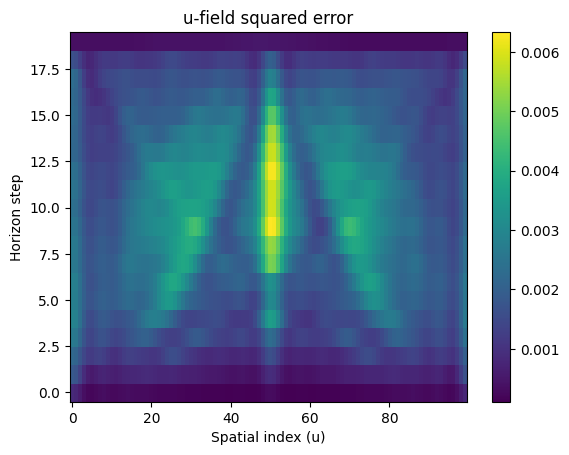

In [15]:
def evaluate_errors(E, F, Xte, Ute, Yte, n_x, m, H, lift_kwargs=None):
    """
    Returns:
      err_traj_step: (N_traj_test, H) per-trajectory MSE at each step
      mse_per_step:  (H,) mean over trajectories
    """
    lift_kwargs = lift_kwargs or {}
    N, Nx = Xte.shape[0], n_x
    err_traj_step = np.zeros((N, H))
    for i in range(N):
        x0 = Xte[i, :, 0]
        psi_xt = psi(x0)                     # (p,)

        U_seq = Ute[i, :, :H].reshape(-1)      # (H*m,)
        Y_true = Yte[i, :, :H].T               # (H, n_x)
        X_pred = open_loop_predict(E, F, psi_xt, U_seq, n_x, H)  # (H, n_x)

        se = (X_pred - Y_true) ** 2            # (H, n_x)
        err_traj_step[i] = se.mean(axis=1)     # per-step MSE for this traj

    mse_per_step = err_traj_step.mean(axis=0)
    return err_traj_step, mse_per_step

def spatial_error_heatmap(E, F, Xte, Ute, Yte, n_x, m, H, lift_kwargs=None):
    lift_kwargs = lift_kwargs or {}
    N = Xte.shape[0]; Nx = n_x // 2
    # accumulate mean squared error over trajectories
    se_mean = np.zeros((H, n_x))
    for i in range(N):
        x0 = Xte[i, :, 0]
        psi_xt = psi(x0)                     # (p,)
        U_seq  = Ute[i, :, :H].reshape(-1)
        Y_true = Yte[i, :, :H].T                    # (H, n_x)
        X_pred = open_loop_predict(E, F, psi_xt, U_seq, n_x, H)
        se_mean += (X_pred - Y_true)**2
    se_mean /= N                                    # (H, n_x)

    import matplotlib.pyplot as plt
    plt.figure()
    plt.imshow(se_mean, aspect='auto', origin='lower')
    plt.xlabel('Spatial index (u)'); plt.ylabel('Horizon step'); plt.title('u-field squared error')
    plt.colorbar()
    plt.show()


spatial_error_heatmap(E, F, X, U, Y, n_x, m, H, lift_kwargs)

In [16]:
import cvxpy as cp
import numpy as np

def mpc_step(E, F, psi_xt, x_ref, Q, R, umin, umax, n_x, m, N):
    """
    One MPC optimization step.
    
    E: (N*n_x, p)
    F: (N*n_x, N*m)
    psi_xt: (p,) lifted state at current x_t
    x_ref: (N, n_x) reference trajectory
    Q: (n_x, n_x) state cost
    R: (m, m) input cost
    umin, umax: (m,) lower/upper bounds for inputs
    """
    # decision variable: stacked inputs over horizon
    U = cp.Variable(N*m)

    # predicted stacked states
    stacked = E @ psi_xt + F @ U   # shape (N*n_x,)
    X_pred = cp.reshape(stacked, (N, n_x))

    # cost
    cost = 0
    for k in range(N):
        cost += cp.quad_form(X_pred[k, :] - x_ref[k, :], Q)
        if k < N:
            u_k = U[k*m:(k+1)*m]
            cost += cp.quad_form(u_k, R)

    # constraints
    constraints = []
    for k in range(N):
        u_k = U[k*m:(k+1)*m]
        constraints += [umin <= u_k, u_k <= umax]

    # solve
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(solver=cp.OSQP, warm_start=True, verbose=False)

    if prob.status not in ["optimal", "optimal_inaccurate"]:
        print("MPC infeasible, status:", prob.status)
        return None

    # return only first control move
    u0 = U.value[:m]
    return u0, X_pred.value

Logged step 10
Norm of state : 2.614328379864249
Applied control u_mpc: [ 0.01620339 -1.          0.46066249  0.53485952 -0.36279946  0.77366266
  0.79014686 -0.10474554]
Logged step 20
Norm of state : 2.8282648567748696
Applied control u_mpc: [ 0.00380446 -0.56945111  0.44989543  0.41959129 -0.0424548   1.
  0.98839373 -0.49603547]
Logged step 30
Norm of state : 2.5262221114340493
Applied control u_mpc: [ 0.03689155 -0.4227344   0.38129074  0.2874902  -0.07211819  1.
  0.81873612 -0.43377716]
Logged step 40
Norm of state : 2.1736310701858774
Applied control u_mpc: [ 0.02891168 -0.35987469  0.33915429  0.24643766 -0.02258971  0.79923679
  0.6717089  -0.31286019]
Logged step 50
Norm of state : 1.8514569981121407
Applied control u_mpc: [ 0.02033673 -0.30212697  0.29459226  0.21570223 -0.00520514  0.65879672
  0.54185242 -0.21595275]
Logged step 60
Norm of state : 1.5531038607799414
Applied control u_mpc: [ 0.01571609 -0.24588383  0.24383695  0.18673751  0.00525141  0.53027569
  0.4440713

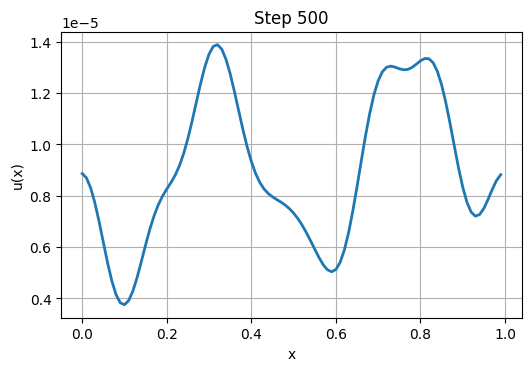

In [17]:
# ------- logging setup -------



from matplotlib.animation import PillowWriter

steps = 500
log_interval = 10
gif_filename = "rad1_profile.gif"
gif_fps = 10

# sizes
n_x = X.shape[1]
m   = U.shape[1]
N   =  X.shape[2]           # or set your MPC horizon explicitly, e.g. N = 20

# costs / constraints
Q = np.eye(n_x) * 1.0
R = np.eye(m)   * 0.001
umin = np.full((m,), -1.0)
umax = np.full((m,),  1.0)

# reference + initial state
x_ref  = np.zeros((N, n_x))
x_curr = X[0, :, 0].copy()
psi_xt = psi(x_curr)

fig, ax = plt.subplots(figsize=(5.2, 3.6), constrained_layout=True)
(line,) = ax.plot(x_grid, x_curr, lw=2)
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.set_title("Step 0")
ax.grid(True)

u_history = []
x_history = [x_curr.copy()]
writer = PillowWriter(fps=gif_fps)
with writer.saving(fig, gif_filename, dpi=100):
    writer.grab_frame()
    for step in range(1, steps + 1):
        # MPC
        u_mpc, X_pred = mpc_step(E, F, psi_xt, x_ref, Q, R, umin, umax, n_x, m, N)
        if u_mpc is None:
            print("MPC failed at step", step); break

        # true step
        x_next = rad1_step(x_curr, u_mpc)

        # log
        if step % log_interval == 0:
            line.set_ydata(x_next)
            ax.set_title(f"Step {step}")
            ax.relim(); ax.autoscale_view()
            writer.grab_frame()     
            print(f"Logged step {step}")
            print("Norm of state :" , np.linalg.norm(x_next))
            print("Applied control u_mpc:", u_mpc)

        # advance
        x_curr = x_next
        psi_xt = psi(x_curr)
        u_history.append(u_mpc)
        x_history.append(x_curr.copy())

print(f"saved {gif_filename}")



(2000, 201)
201


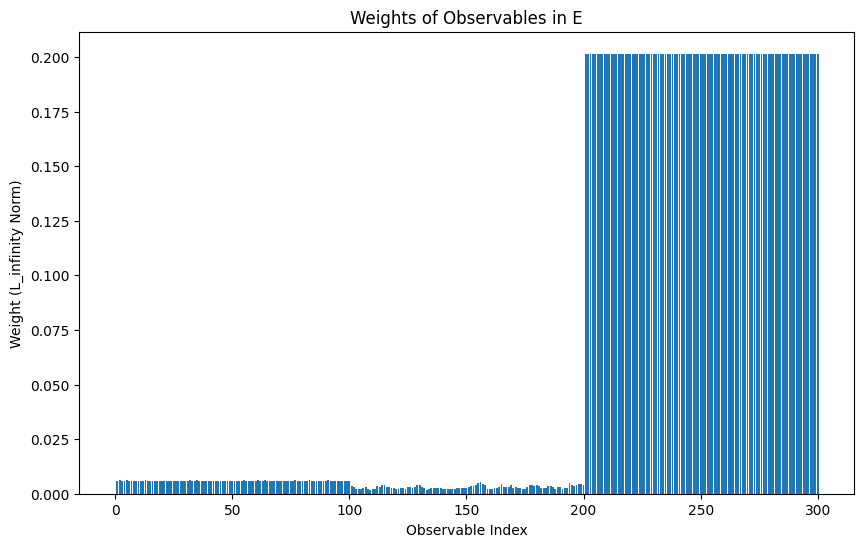

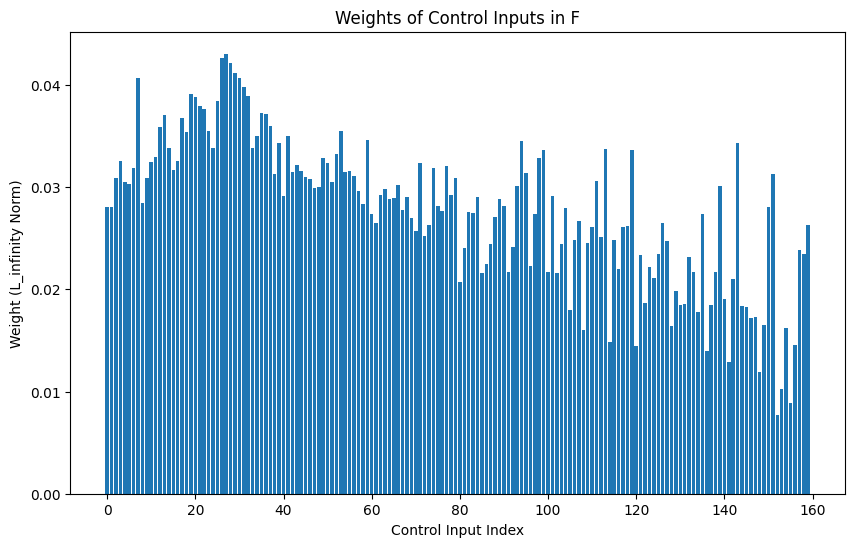

In [25]:
def prune(E,eps_E):
    idx = []
    for i in range(E.shape[1]):
        if np.linalg.norm(E[:,i],ord =float('inf')) > eps_E:
            idx.append(i)
    E_pruned = E[:,idx]

    return E_pruned, idx

E_pruned, idx = prune(E,5e-3)
print(E_pruned.shape)
print(len(idx))


def plot_obsevable_weights(E):
    """
    Plot the weights of the observables in E.
    """

    num_observables = E.shape[1]
    weights = np.linalg.norm(E, ord = float('inf'), axis=0)

    plt.figure(figsize=(10, 6))
    plt.bar(range(num_observables), weights)
    plt.xlabel('Observable Index')
    plt.ylabel('Weight (L_infinity Norm)')
    plt.title('Weights of Observables in E')
    plt.show()

plot_obsevable_weights(E)


def plot_control_weights(F):
    """
    Plot the weights of the control inputs in F.
    """

    num_controls = F.shape[1]
    weights = np.linalg.norm(F, ord = float('inf'), axis=0)

    plt.figure(figsize=(10, 6))
    plt.bar(range(num_controls), weights)
    plt.xlabel('Control Input Index')
    plt.ylabel('Weight (L_infinity Norm)')
    plt.title('Weights of Control Inputs in F')
    plt.show()
plot_control_weights(F)
def prune_observables(psi_xt, idx):
    """
    Prune the observables in psi_xt based on the indices in idx.
    """
    return psi_xt[idx]

In [26]:
#compute pruned open loop error and save
mse_per_step_pruned = evaluate_mse_over_horizon(E_pruned, F, X, U, Y, n_x, m, H, psi=lambda x: prune_observables(psi(x), idx), flatten_order="time")
for k in range(H):
    print(f"Pruned Step {k+1}, MSE: {mse_per_step_pruned[k]:.3e}")
np.savez_compressed("rad1_multistep_pruned_errors.npz", mse_pruned=mse_per_step_pruned)

Pruned Step 1, MSE: 1.099e-12
Pruned Step 2, MSE: 5.956e-04
Pruned Step 3, MSE: 8.944e-04
Pruned Step 4, MSE: 1.302e-03
Pruned Step 5, MSE: 1.297e-03
Pruned Step 6, MSE: 1.793e-03
Pruned Step 7, MSE: 1.960e-03
Pruned Step 8, MSE: 2.295e-03
Pruned Step 9, MSE: 2.063e-03
Pruned Step 10, MSE: 2.729e-03
Pruned Step 11, MSE: 2.922e-03
Pruned Step 12, MSE: 3.252e-03
Pruned Step 13, MSE: 3.254e-03
Pruned Step 14, MSE: 3.523e-03
Pruned Step 15, MSE: 3.760e-03
Pruned Step 16, MSE: 4.035e-03
Pruned Step 17, MSE: 3.829e-03
Pruned Step 18, MSE: 4.304e-03
Pruned Step 19, MSE: 4.264e-03
Pruned Step 20, MSE: 4.591e-03


Logged step 10
Norm of state : 2.6013821582926773
Applied control u_mpc: [ 0.01321885 -1.          0.47451873  0.50445613 -0.3337252   0.76280667
  0.75434486 -0.12647254]
Logged step 20
Norm of state : 2.7916447994067273
Applied control u_mpc: [ 0.00877335 -0.55567074  0.44315061  0.38936129 -0.04399191  1.
  0.91834146 -0.45877493]
Logged step 30
Norm of state : 2.4781469797241287
Applied control u_mpc: [ 0.03526638 -0.41398813  0.37056912  0.26933291 -0.04362189  0.95480043
  0.75721085 -0.39451326]
Logged step 40
Norm of state : 2.125093948869282
Applied control u_mpc: [ 0.02806528 -0.35271052  0.33161334  0.22295481 -0.013448    0.77773904
  0.63176838 -0.30504733]
Logged step 50
Norm of state : 1.813127658977056
Applied control u_mpc: [ 0.01931275 -0.30829376  0.28811541  0.19103999 -0.00335803  0.64525035
  0.51748141 -0.23774846]
Logged step 60
Norm of state : 1.5416668450778679
Applied control u_mpc: [ 0.01254322 -0.26160028  0.24452028  0.16436808  0.0025978   0.53634681
  0.

KeyboardInterrupt: 

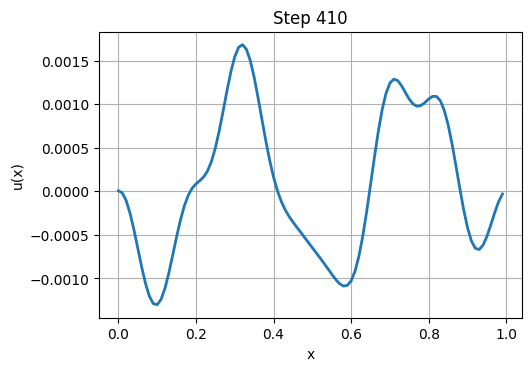

In [27]:
# ------- logging setup -------
# repeat for pruned observables -------
from matplotlib.animation import PillowWriter
steps = 500
log_interval = 10
gif_filename = "rad1_mpc_control_pruned.gif"
gif_fps = 10
# --- assume these already exist: X, U, Nx, x_grid, Ts, psi, E_pruned, F, mpc_step, rad1_step ---
# sizes (define BEFORE using them)
n_x = X.shape[1]
m   = U.shape[1]
N   = X.shape[2]               # if your MPC horizon is different, set it
# costs and constraints
Q = np.eye(n_x) * 1.0
R = np.eye(m)   * 0.01
umin = np.full((m,), -1.0)
umax = np.full((m,),  1.0)
# reference and initial state
x_ref  = np.zeros((N, n_x))    # zero reference
x_curr = X[0, :, 0].copy()     # initial state
psi_xt_full = psi(x_curr)
psi_xt = prune_observables(psi_xt_full, idx)
#mpc
fig, ax = plt.subplots(figsize=(5.2, 3.6), constrained_layout=True)
(line,) = ax.plot(x_grid, x_curr, lw=2)
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.set_title("Step 0")
ax.grid(True)
u_history_pruned = []
x_history_pruned = [x_curr.copy()]
writer = PillowWriter(fps=gif_fps)
with writer.saving(fig, gif_filename, dpi=100):
    writer.grab_frame()
    for step in range(1, steps + 1):
        # MPC
        u_mpc, X_pred = mpc_step(E_pruned, F, psi_xt, x_ref, Q, R, umin, umax, n_x, m, N)
        if u_mpc is None:
            print("MPC failed at step", step); break

        # true step
        x_next = rad1_step(x_curr, u_mpc)

        # log
        if step % log_interval == 0:
            line.set_ydata(x_next)
            ax.set_title(f"Step {step}")
            ax.relim(); ax.autoscale_view()
            writer.grab_frame()     
            print(f"Logged step {step}")
            print("Norm of state :" , np.linalg.norm(x_next))
            print("Applied control u_mpc:", u_mpc)

        # advance
        x_curr = x_next
        psi_xt_full = psi(x_curr)
        psi_xt = prune_observables(psi_xt_full, idx)
        u_history_pruned.append(u_mpc)
        x_history_pruned.append(x_curr.copy())


In [ ]:
np.savez_compressed("rad1_edmdc_initial_only_EF_pruned.npz", E=E_pruned, F=F)
#save u and x history
u_history_pruned = np.array(u_history_pruned)
x_history_pruned = np.array(x_history_pruned)
np.savez_compressed("rad1_mpc_control_pruned_history.npz", u_history=u_history_pruned, x_history=x_history_pruned)
#save not prined
u_history = np.array(u_history)
x_history = np.array(x_history)
np.savez_compressed("rad1_mpc_control_history.npz", u_history=u_history, x_history=x_history)

